In [1]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
pronostico = pd.read_csv("weatherAUS.csv")

In [3]:
pronostico.info() # 145460

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.

In [4]:
pronostico["Date"] = pd.to_datetime(pronostico["Date"])

### Creacion de columnas nuevas

#### Creacion de columnas de tiempo y categoricas como estacion del año y simplificación de la direccion del viento

In [5]:
# Creamos variables de fecha, para poder mejorar el modelo.

pronostico["dia"] = pronostico["Date"].dt.day
pronostico["mes"] = pronostico["Date"].dt.month
pronostico["año"] = pronostico["Date"].dt.year

In [ ]:
def categorizar_rainfall(mm):
    """
    Categorizamos la cantidad de lluvia en mm en diferentes niveles.
    Args:
        mm (float): Cantidad de lluvia en mm.
    Returns:
        str: Categoría de lluvia.
    """
    if mm == 0:
        return 'Ninguna'
    elif mm < 2.5:
        return 'Leve'
    elif mm < 10:
        return 'Moderada'
    else:
        return 'Fuerte'

In [7]:
def simplify_wind_direction(dir):
    """
    Simplifica la dirección del viento a cardinales.
    Args:
        dir (str): Dirección del viento original.
    Returns:
        str: Dirección simplificada (N: Norte, S: Sur, E: Este, O: Oeste, C: Calma).
    """
    if dir in ['N', 'NNE', 'NNW']:
        return 'N'
    elif dir in ['S', 'SSE', 'SSW']:
        return 'S'
    elif dir in ['E', 'ENE', 'ESE']:
        return 'E'
    elif dir in ['W', 'WNW', 'WSW']:
        return 'O'
    else:
        return 'C'

In [8]:
def obtener_estacion_australia(mes, dia):
    """
    Obtenemos la estación del año en Australia según el mes y el día.
    Args:
        mes (int): Mes del año (1-12).
        dia (int): Día del mes (1-31).
    Returns:
        str: Estación del año ('verano', 'otoño', 'invierno', 'primavera').
    """
    if (mes == 12 and dia >= 21) or mes in [1, 2] or (mes == 3 and dia < 21):
        return 'verano'
    elif (mes == 3 and dia >= 21) or mes in [4, 5] or (mes == 6 and dia < 21):
        return 'otoño'
    elif (mes == 6 and dia >= 21) or mes in [7, 8] or (mes == 9 and dia < 21):
        return 'invierno'
    elif (mes == 9 and dia >= 21) or mes in [10, 11] or (mes == 12 and dia < 21):
        return 'primavera'

In [ ]:
# Creamos variables, estacion, direccion viento y tipo de lluvia para simplificar la informacion del dataset.

pronostico['Estacion'] = pronostico.apply(lambda row: obtener_estacion_australia(row['mes'], row['dia']), axis=1)
pronostico['Direccion_viento'] = pronostico['WindGustDir'].apply(simplify_wind_direction)
pronostico['Tipo_lluvia'] = pronostico['Rainfall'].apply(categorizar_rainfall) # Consultar si nos quedamos con esta, o con Rainfall

#### Creacion de regiones

##### Grafico de las ciudades

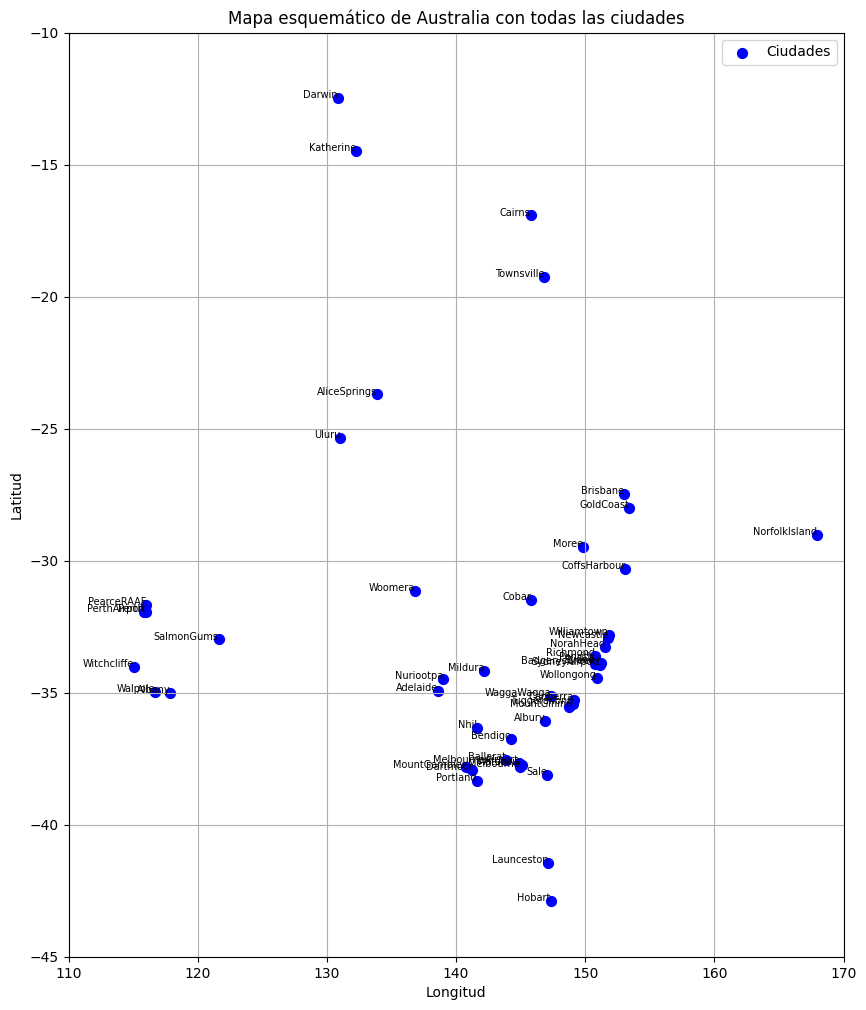

In [11]:
# Diccionario extendido con coordenadas aproximadas
city_coords = {
    'Albury': (-36.08, 146.92),
    'BadgerysCreek': (-33.92, 150.78),
    'Cobar': (-31.50, 145.83),
    'CoffsHarbour': (-30.30, 153.11),
    'Moree': (-29.47, 149.84),
    'Newcastle': (-32.93, 151.78),
    'NorahHead': (-33.28, 151.57),
    'NorfolkIsland': (-29.04, 167.95),
    'Penrith': (-33.75, 150.69),
    'Richmond': (-33.60, 150.75),
    'Sydney': (-33.87, 151.21),
    'SydneyAirport': (-33.94, 151.18),
    'WaggaWagga': (-35.11, 147.37),
    'Williamtown': (-32.80, 151.84),
    'Wollongong': (-34.43, 150.89),
    'Canberra': (-35.28, 149.13),
    'Tuggeranong': (-35.42, 149.07),
    'MountGinini': (-35.53, 148.77),
    'Ballarat': (-37.56, 143.85),
    'Bendigo': (-36.76, 144.28),
    'Sale': (-38.11, 147.07),
    'MelbourneAirport': (-37.67, 144.84),
    'Melbourne': (-37.81, 144.96),
    'Mildura': (-34.19, 142.16),
    'Nhil': (-36.33, 141.65),
    'Portland': (-38.34, 141.60),
    'Watsonia': (-37.72, 145.08),
    'Dartmoor': (-37.92, 141.27),
    'Brisbane': (-27.47, 153.03),
    'Cairns': (-16.92, 145.77),
    'GoldCoast': (-28.00, 153.43),
    'Townsville': (-19.26, 146.82),
    'Adelaide': (-34.93, 138.60),
    'MountGambier': (-37.83, 140.78),
    'Nuriootpa': (-34.47, 138.99),
    'Woomera': (-31.15, 136.80),
    'Albany': (-35.02, 117.88),
    'Witchcliffe': (-34.01, 115.10),
    'PearceRAAF': (-31.67, 116.02),
    'PerthAirport': (-31.94, 115.97),
    'Perth': (-31.95, 115.86),
    'SalmonGums': (-32.98, 121.63),
    'Walpole': (-34.98, 116.73),
    'Hobart': (-42.88, 147.33),
    'Launceston': (-41.44, 147.14),
    'AliceSprings': (-23.70, 133.88),
    'Darwin': (-12.46, 130.84),
    'Katherine': (-14.47, 132.26),
    'Uluru': (-25.34, 131.03)
}

plt.figure(figsize=(10, 12))
plt.scatter(
    [lon for lat, lon in city_coords.values()],
    [lat for lat, lon in city_coords.values()],
    s=50, c='blue', label='Ciudades'
)
for city, (lat, lon) in city_coords.items():
    plt.text(lon, lat, city, fontsize=7, ha='right')

plt.title('Mapa esquemático de Australia con todas las ciudades')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(110, 170)
plt.ylim(-45, -10)
plt.grid(True)
plt.legend()
plt.show()

##### Agrupamos por ciudades

In [12]:
region_dict = {
    'New South Wales': [
        'Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
        'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
        'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong'
    ],
    'Australian Capital Territory': [
        'Canberra', 'Tuggeranong', 'MountGinini'
    ],
    'Victoria': [
        'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne',
        'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor'
    ],
    'Queensland': [
        'Brisbane', 'Cairns', 'GoldCoast', 'Townsville'
    ],
    'South Australia': [
        'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'
    ],
    'Western Australia': [
        'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth',
        'SalmonGums', 'Walpole'
    ],
    'Tasmania': [
        'Hobart', 'Launceston'
    ],
    'Northern Territory': [
        'AliceSprings', 'Darwin', 'Katherine', 'Uluru'
    ]
}

def asignar_region(ciudad):
    for region, ciudades in region_dict.items():
        if ciudad in ciudades:
            return region
    return 'Other'

pronostico['Region'] = pronostico['Location'].apply(asignar_region)

## Analisis descriptivo

In [13]:
# Verificamos que no haya nulos en la columna RainTomorrow.
print(f"{pronostico["RainTomorrow"].isna().sum()} nulos en nuestra columna objetivo")

#Eliminamos los nulos
pronostico = pronostico.dropna(subset=["RainTomorrow"])

3267 nulos en nuestra columna objetivo


### Division del dataset

In [14]:
# Eliminamos las columnas Date y RainTomorrow, una es la que vamos a predecir y la otra es la no nos sirve para el modelo.
X = pronostico.drop(labels =['Date','RainTomorrow', 'Location', 'WindGustDir'], axis = 1)
y = pronostico['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Valores nulos

In [15]:
def rellenar_nulos_numericos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los valores nulos numericos del dataframe con la mediana de la columna, por mes y región.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Rellenar los valores nulos con la mediana de la columna
        df[col] = df.groupby(['mes', 'Region'])[col].transform(lambda x: x.fillna(x.median()))

    return df

In [16]:
def rellenar_nulos_categoricos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los valores nulos categoricos del dataframe con la moda de la columna, por mes y por region.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """
    
    for col in df.select_dtypes(include=['object']).columns:
        # Rellenar los valores nulos con la moda de la columna
        df[col] = df.groupby(['mes','Region'])[col].transform(lambda x: x.fillna(x.mode()[0]))
    
    return df

In [17]:
X_train.isna().sum()

MinTemp                525
MaxTemp                268
Rainfall              1182
Evaporation          48791
Sunshine             54345
WindGustSpeed         7406
WindDir9am            8036
WindDir3pm            3023
WindSpeed9am          1083
WindSpeed3pm          2109
Humidity9am           1420
Humidity3pm           2913
Pressure9am          11257
Pressure3pm          11225
Cloud9am             43041
Cloud3pm             45767
Temp9am                736
Temp3pm               2206
RainToday             1182
dia                      0
mes                      0
año                      0
Estacion                 0
Direccion_viento         0
Tipo_lluvia              0
Rango_temperatura      719
Region                   0
dtype: int64

In [18]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,dia,mes,año,Rango_temperatura
count,113229.000000,113486.000000,112572.000000,64963.000000,59409.000000,106348.000000,112671.000000,111645.000000,112334.000000,110841.000000,102497.000000,102529.000000,70713.000000,67987.000000,113018.000000,111548.000000,113754.000000,113754.000000,113754.000000,113035.000000
mean,12.176037,23.222816,2.347680,5.470719,7.622586,39.957395,13.994169,18.626325,68.824764,51.466659,1017.651395,1015.258031,4.433188,4.500478,16.983173,21.681986,15.707826,6.400891,2012.757802,11.048084
std,6.398791,7.118185,8.466572,4.229935,3.778445,13.574900,8.884425,8.790884,19.063076,20.799362,7.111363,7.040286,2.886888,2.722538,6.491592,6.939722,8.797404,3.423346,2.541504,4.950884
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-7.200000,-5.400000,1.000000,1.000000,2007.000000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,8.000000,3.000000,2011.000000,7.200000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,16.000000,6.000000,2013.000000,10.500000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,23.000000,9.000000,2015.000000,14.500000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1038.900000,8.000000,9.000000,40.200000,46.700000,31.000000,12.000000,2017.000000,31.200000


In [19]:
X_train = rellenar_nulos_numericos(X_train) # Rellenamos los nulos numricos
X_train = rellenar_nulos_categoricos(X_train) # Rellenamos los nulos categoricos

### Graficos

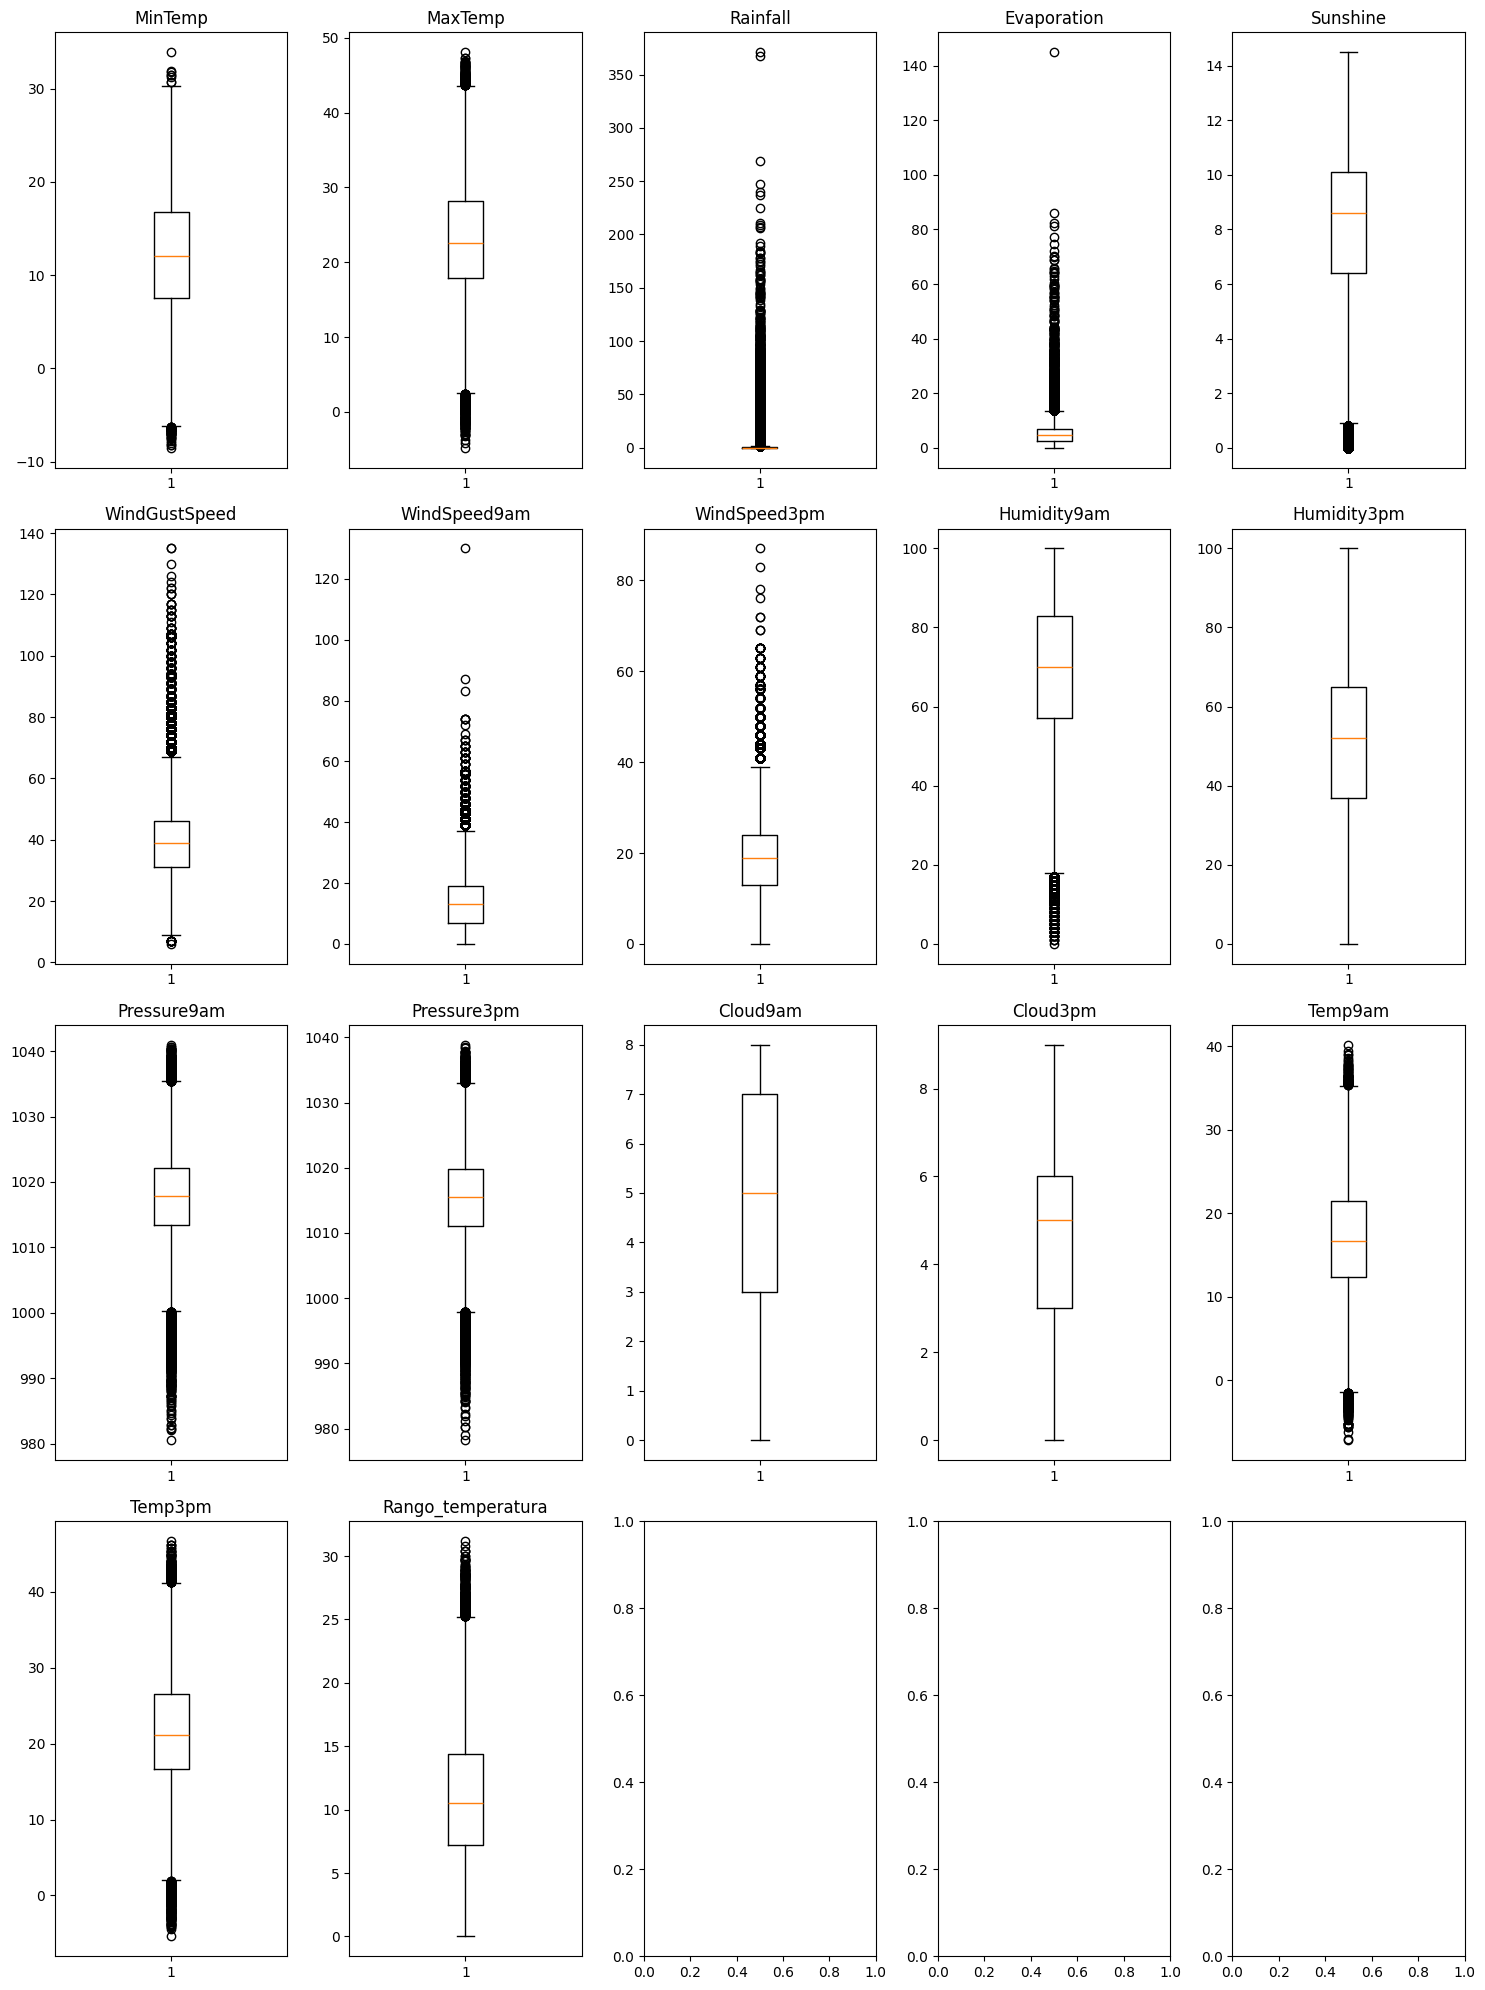

In [ ]:
# Obtenemos las columnas numericos
numericas = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

# Graficamos los boxplot de las columnas numericas
fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos
for i, columans in enumerate(numericas):
    axis[i].boxplot(X_train[columans])
    axis[i].set_title(columans)

plt.tight_layout()
plt.show()

Se pueden apreciar presencia de valores atipico, pero la mayoria de ellos seria de cuando llueve, y/o relacionadas a otras variables que podrian explicarse. Variables como Evaporation o Rainfall, aparecen que tienen muchisimo valores atipico, pero se pueden explicarse debido a que no siempre llovia.

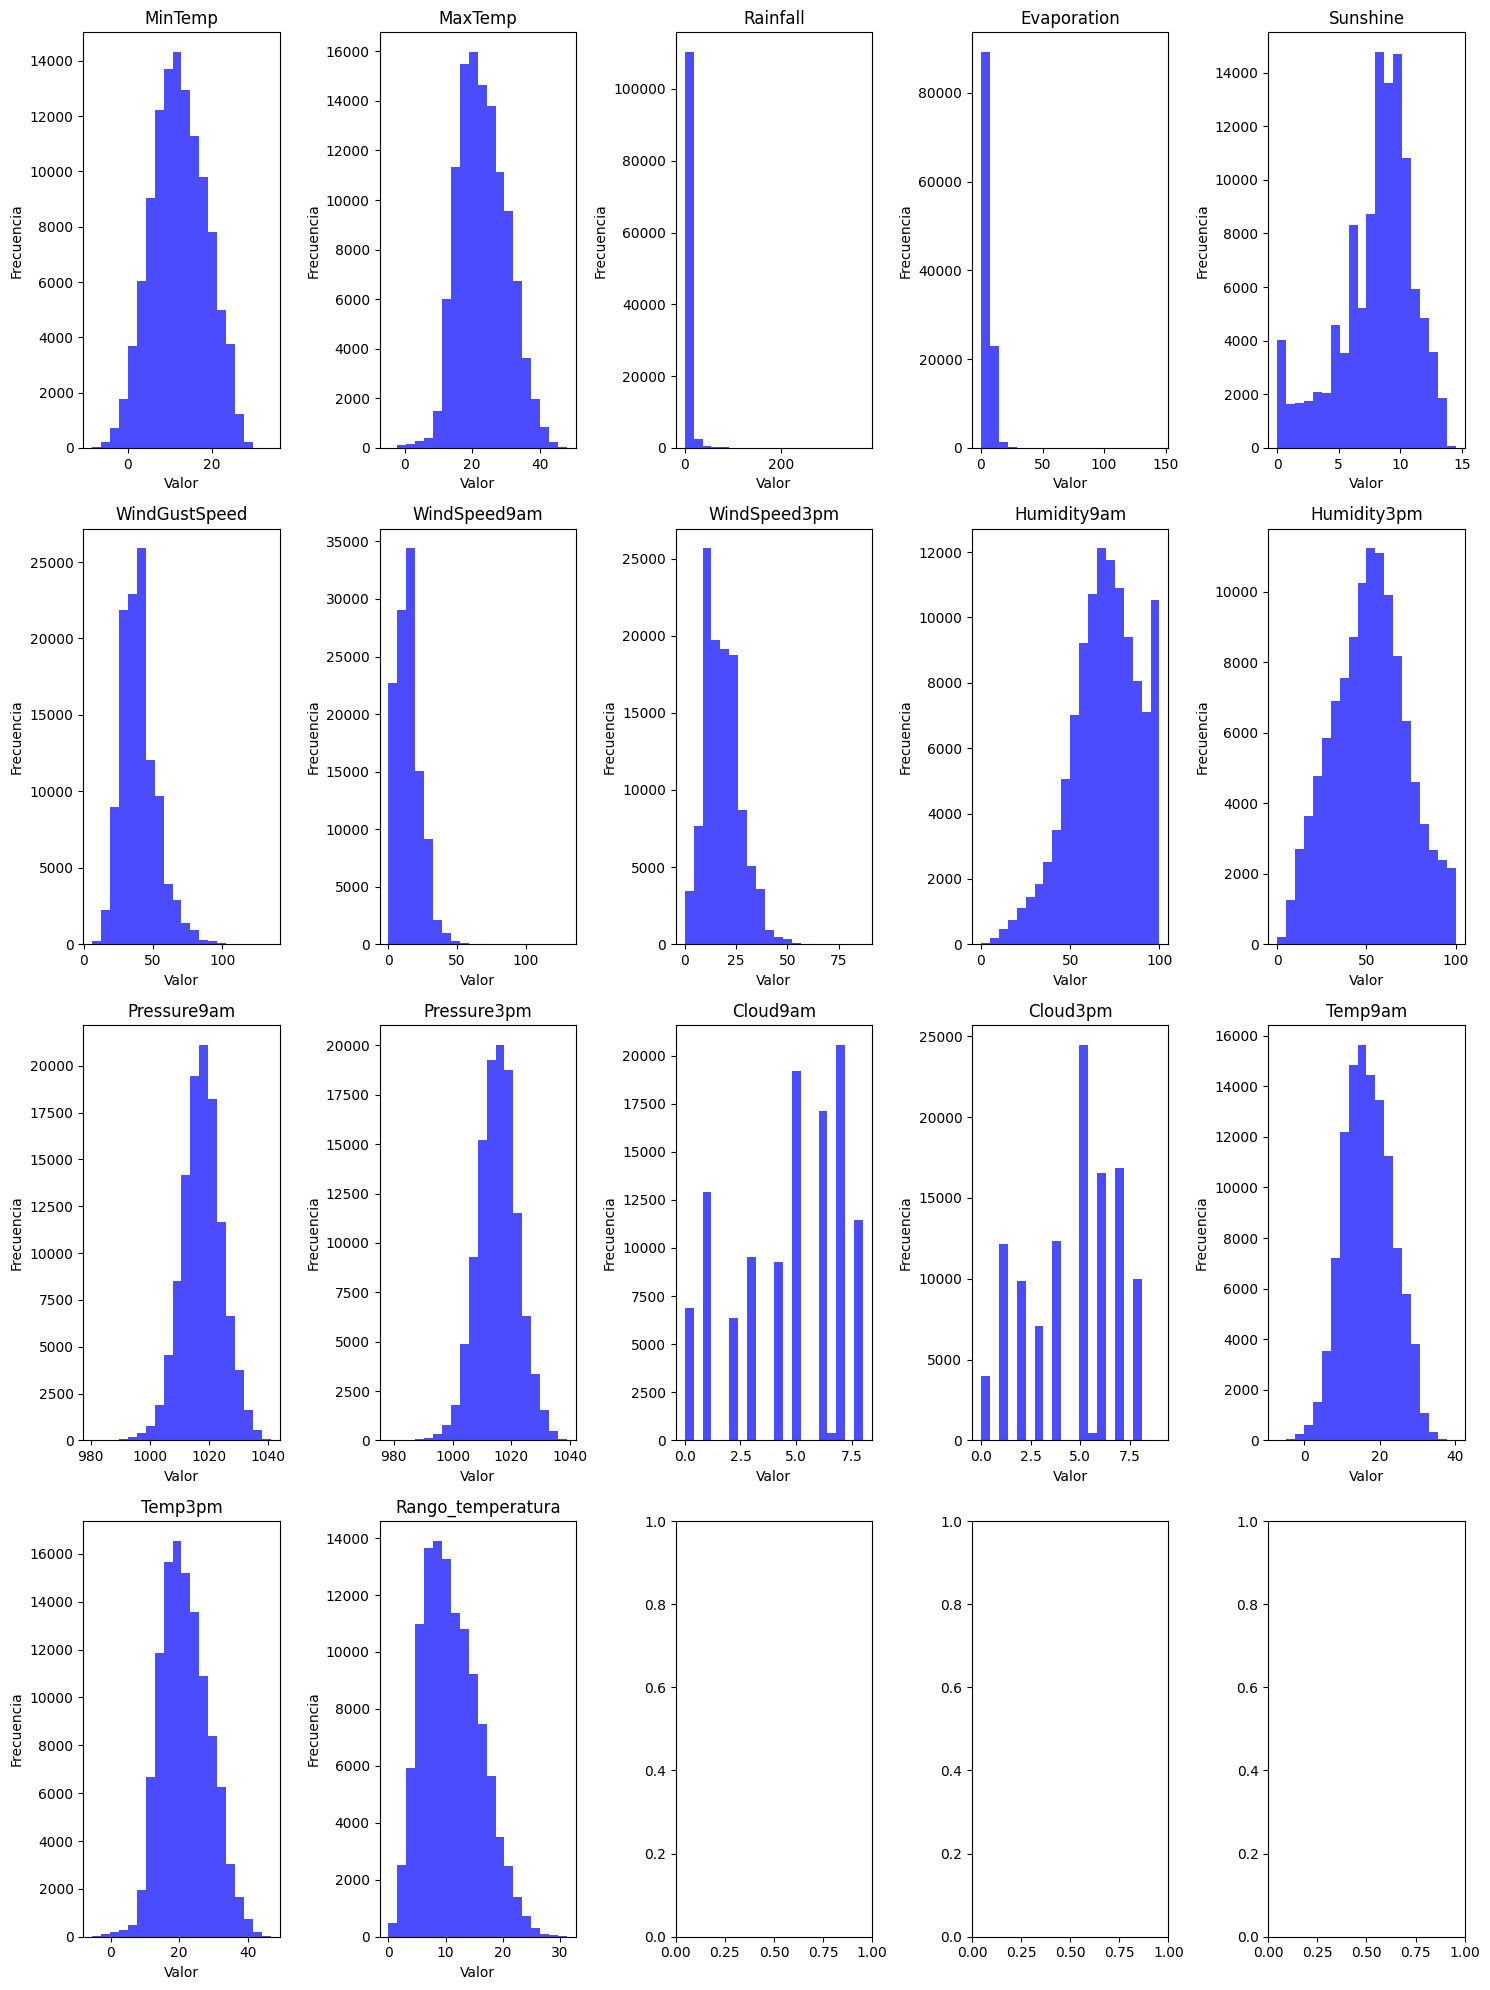

In [ ]:
# histograma

fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos

for i, columans in enumerate(numericas):
    axis[i].hist(X_train[columans], bins=20, color='blue', alpha=0.7)
    axis[i].set_title(columans)
    axis[i].set_xlabel('Valor')
    axis[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

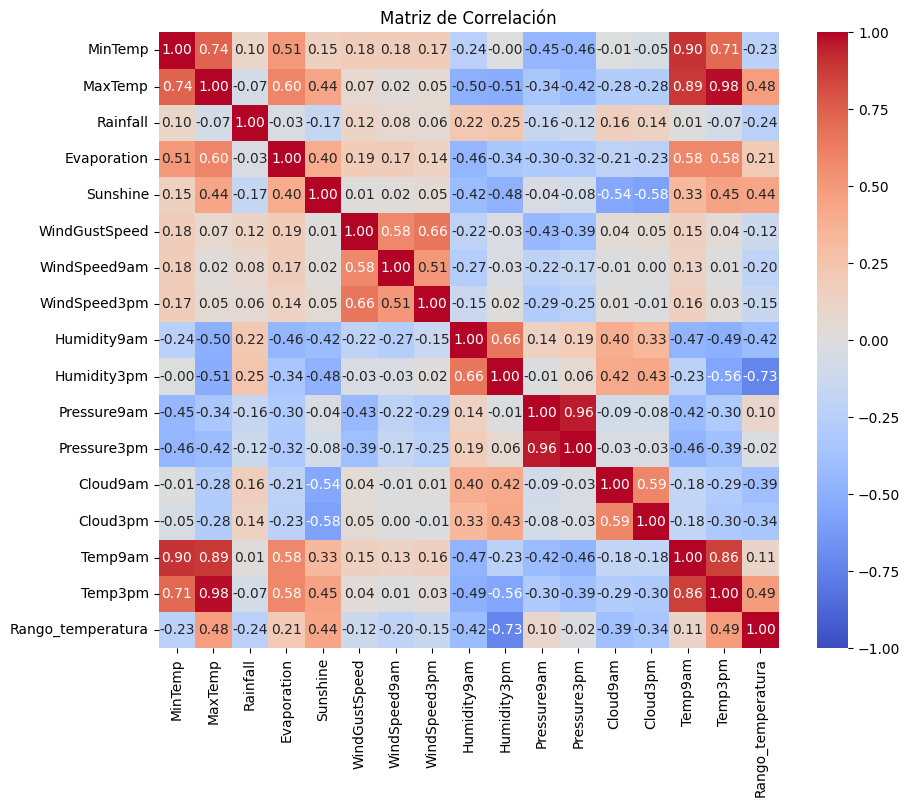

In [22]:
# Matriz de correlacion

correlacion = X_train[numericas].corr()

# Visualizamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

In [23]:
# Verificamos si la variable target está balanceada
no, si = y_train.value_counts()
total = no + si
print(f"Porcentaje de lluvia: {si/total*100:.2f}%")

Porcentaje de lluvia: 22.45%


Se puede apreciar que se encuentra desbalanciado, con un 22.45% de valores que predicen que va a llover

### Estandarización